In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
dir_path = '/content/drive/My Drive/CS 280/dataset-resized'

classes = ('cardboard','glass', 'metal', 'paper', 'plastic', 'trash')
num_classes = 6

In [0]:
train_datagen=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1)
val_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator=train_datagen.flow_from_directory(dir_path,
                                                  target_size=(224,224),
                                                  batch_size=128,
                                                  class_mode='categorical',
                                                  subset='training',
                                                  seed = 30)

val_generator=val_datagen.flow_from_directory(dir_path,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='validation',
                                              seed = 30)

Found 2293 images belonging to 6 classes.
Found 252 images belonging to 6 classes.


In [0]:
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Dropout, Input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import itertools
%matplotlib inline

vgg16_model = tensorflow.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
for layer in vgg16_model.layers[:-4]:
    layer.trainable = False


vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg16_model)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()
  

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              25691136  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 32,776,710
Non-trainable params: 7,635,264
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath='/content/drive/My Drive/CS 280/vgg+softmax final.h5'
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, mode='max', save_best_only=True)
callbacks_list = [checkpoint1]

model.compile(loss='categorical_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=val_generator,
      validation_steps=val_generator.samples/val_generator.batch_size,
      verbose=1,
      callbacks=callbacks_list)

Epoch 1/100
18/17 [==============================] - ETA: 0s - loss: 2.0271 - acc: 0.3489
Epoch 00001: val_acc improved from -inf to 0.48016, saving model to /content/drive/My Drive/CS 280/vgg+softmax final.h5
18/17 [==============================] - 39s 2s/step - loss: 2.0271 - acc: 0.3489 - val_loss: 1.2135 - val_acc: 0.4802
Epoch 2/100
18/17 [==============================] - ETA: 0s - loss: 1.2268 - acc: 0.5290
Epoch 00002: val_acc improved from 0.48016 to 0.60714, saving model to /content/drive/My Drive/CS 280/vgg+softmax final.h5
18/17 [==============================] - 39s 2s/step - loss: 1.2268 - acc: 0.5290 - val_loss: 0.9264 - val_acc: 0.6071
Epoch 3/100
18/17 [==============================] - ETA: 0s - loss: 1.0383 - acc: 0.6079
Epoch 00003: val_acc improved from 0.60714 to 0.64286, saving model to /content/drive/My Drive/CS 280/vgg+softmax final.h5
18/17 [==============================] - 40s 2s/step - loss: 1.0383 - acc: 0.6079 - val_loss: 0.9102 - val_acc: 0.6429
Epoch 4

In [0]:
model.save('/content/drive/My Drive/CS 280/vgg+softmax last.h5')

In [0]:
np.save('/content/drive/My Drive/CS 280/VGG+softmax history.npy', history.history) 

In [0]:
read_dictionary = np.load('/content/drive/My Drive/CS 280/VGG+softmax history.npy',allow_pickle='TRUE').item()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


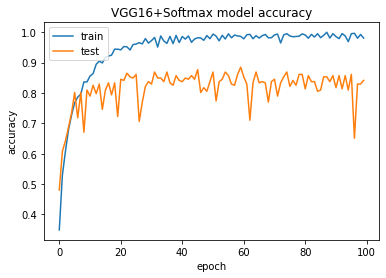

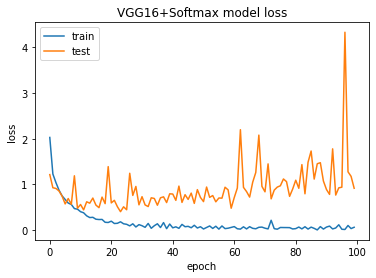

In [0]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('VGG16+Softmax model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16+Softmax model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model.evaluate_generator(generator=val_generator,steps=val_generator.samples/val_generator.batch_size)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[1.3618574142456055, 0.8333333134651184]

In [0]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/My Drive/CS 280/vgg+softmax final.h5')

In [0]:
best_model.evaluate_generator(generator=val_generator,steps=val_generator.samples/val_generator.batch_size)

[0.5225390791893005, 0.8492063283920288]